
# Track solidification of a metallic alloy

In this example, we identify and track the solid-liquid (S-L) interface in a
nickel-based alloy undergoing solidification. Tracking the solidification over
time enables the calculatation of the solidification velocity. This is
important to characterize the solidified structure of the sample and will be
used to inform research into additive manufacturing of metals. The image
sequence was obtained by the Center for Advanced Non-Ferrous Structural Alloys
(CANFSA) using synchrotron x-radiography at the Advanced Photon Source (APS)
at Argonne National Laboratory (ANL). This analysis was first presented at
a conference [1]_.

.. [1] Corvellec M. and Becker C. G. (2021, May 17-18)
       "Quantifying solidification of metallic alloys with scikit-image"
       [Conference presentation]. BIDS ImageXD 2021 (Image Analysis Across
       Domains). Virtual participation.
       https://www.youtube.com/watch?v=cB1HTgmWTd8


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io

from skimage import filters, measure, restoration
from skimage.data import nickel_solidification

image_sequence = nickel_solidification()

y0, y1, x0, x1 = 0, 180, 100, 330

image_sequence = image_sequence[:, y0:y1, x0:x1]

print(f'shape: {image_sequence.shape}')

shape: (11, 180, 230)


The dataset is a 2D image stack with 11 frames (time points).
We visualize and analyze it in a workflow where the first image processing
steps are performed on the entire three-dimensional dataset (i.e., across
space and time),
such that the removal of localized, transient noise is favored as
opposed to that of physical features (e.g., bubbles, splatters, etc.), which
exist in roughly the same position from one frame to the next.



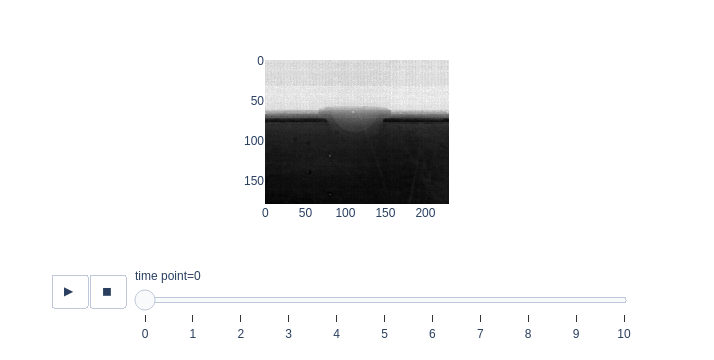

In [2]:
fig = px.imshow(
    image_sequence,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'time point'}
)
plotly.io.show(fig)

## Compute image deltas
Let us first apply a Gaussian low-pass filter in order to smooth
the images and reduce noise.
Next, we compute the image deltas, i.e., the sequence of differences
between two consecutive frames. To do this, we subtract the image sequence
ending at the second-to-last frame from the image sequence starting
at the second frame.



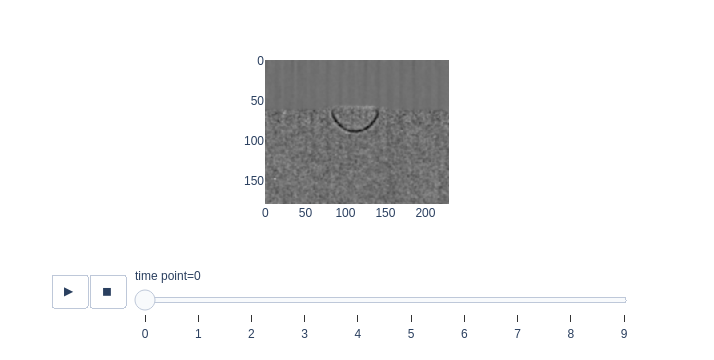

In [3]:
smoothed = filters.gaussian(image_sequence)
image_deltas = smoothed[1:, :, :] - smoothed[:-1, :, :]

fig = px.imshow(
    image_deltas,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'time point'}
)
plotly.io.show(fig)

## Clip lowest and highest intensities
We now calculate the 5th and 95th percentile intensities of ``image_deltas``:
We want to clip the intensities which lie below the 5th percentile
intensity and above the 95th percentile intensity, while also rescaling
the intensity values to [0, 1].



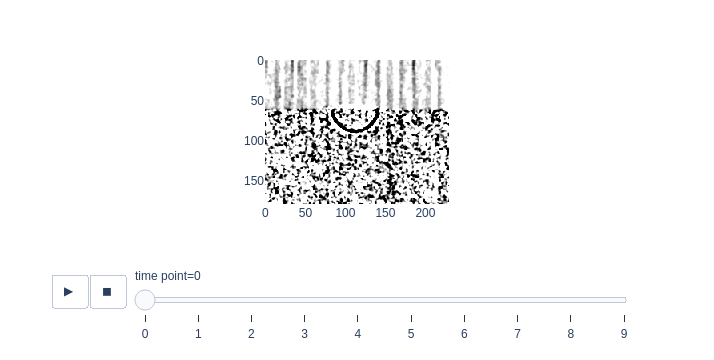

In [4]:
p_low, p_high = np.percentile(image_deltas, [5, 95])
clipped = image_deltas - p_low
clipped[clipped < 0.0] = 0.0
clipped = clipped / p_high
clipped[clipped > 1.0] = 1.0

fig = px.imshow(
    clipped,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'time point'}
)
plotly.io.show(fig)

## Invert and denoise
We invert the ``clipped`` images so the regions of highest intensity
will include the region we are interested in tracking (i.e., the
S-L interface). Then, we apply a total variation denoising filter to reduce
noise beyond the interface.



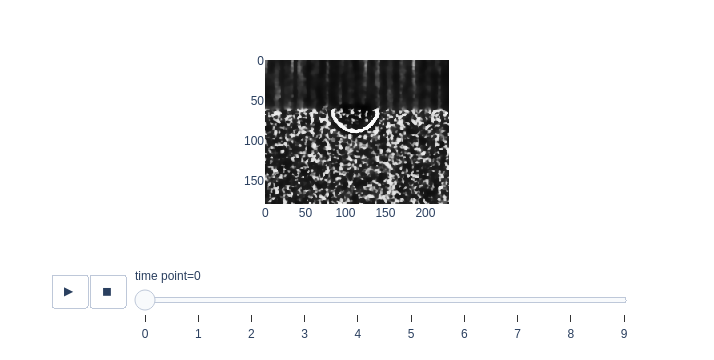

In [5]:
inverted = 1 - clipped
denoised = restoration.denoise_tv_chambolle(inverted, weight=0.15)

fig = px.imshow(
    denoised,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'time point'}
)
plotly.io.show(fig)

## Binarize
Our next step is to create binary images, splitting the images
into foreground and background: We want the S-L interface
to be the most prominent feature in the foreground of each binary image,
so that it can eventually be separated from the rest of the image.

We need
a threshold value ``thresh_val`` to create our binary images, ``binarized``.
This can be set manually, but we shall use an automated minimum threshold
method from the ``filters`` submodule of scikit-image (there are other
methods that may work better for different applications).



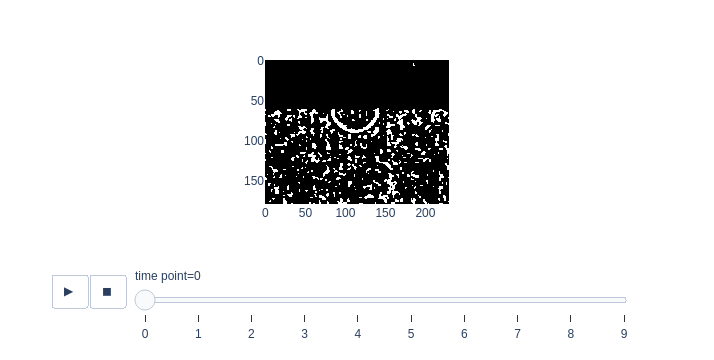

In [6]:
thresh_val = filters.threshold_minimum(denoised)
binarized = denoised > thresh_val

fig = px.imshow(
    binarized,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'time point'}
)
plotly.io.show(fig)

## Select largest region
In our binary images, the S-L interface appears as the largest region of
connected pixels. For this step of the workflow, we will operate on each
2D image separately, as opposed to the entire 3D dataset, because we are
interested in a single moment in time for each region.

We apply :func:`skimage.measure.label()` on the binary images so that each
region has its own label. Then, we select the largest region in each image
by computing region properties, including the ``area`` property, and
sorting by ``area`` values. Function
:func:`skimage.measure.regionprops_table()` returns a table of region
properties which can be read into a Pandas ``DataFrame``.
To begin with, let us consider the first image delta at this stage of the
workflow, ``binarized[0, :, :]``.



In [7]:
labeled_0 = measure.label(binarized[0, :, :])
props_0 = measure.regionprops_table(
        labeled_0, properties=('label', 'area', 'bbox'))
props_0_df = pd.DataFrame(props_0)
props_0_df = props_0_df.sort_values('area', ascending=False)
# Show top five rows
props_0_df.head()

label   area  bbox-0  bbox-1  bbox-2  bbox-3
1        2  417.0      60      83      91     144
198    199  235.0     141     141     179     165
11      12  136.0      62     164      87     180
9       10  122.0      61     208      79     229
8        9  114.0      61     183      83     198

We can thus select the largest region by matching its label with the one
found in the first row of the above (sorted) table. Let us visualize it,
along with its bounding box (bbox) in red.



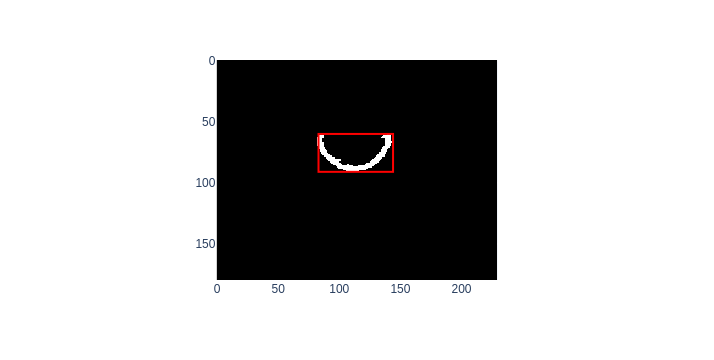

In [8]:
largest_region_0 = labeled_0 == props_0_df.iloc[0]['label']
minr, minc, maxr, maxc = (props_0_df.iloc[0][f'bbox-{i}'] for i in range(4))
fig = px.imshow(largest_region_0, binary_string=True)
fig.add_shape(
        type='rect', x0=minc, y0=minr, x1=maxc, y1=maxr, line=dict(color='Red'))
plotly.io.show(fig)

We can see how the lower bounds of the box align with the bottom of the
S-L interface by overlaying the same bounding box onto the 0th raw image.
This bounding box was calculated from the image delta between
the 0th and 1st images, but the bottom-most region of the box
corresponds to the location of the interface earlier
in time (0th image) because the interface is moving upward.



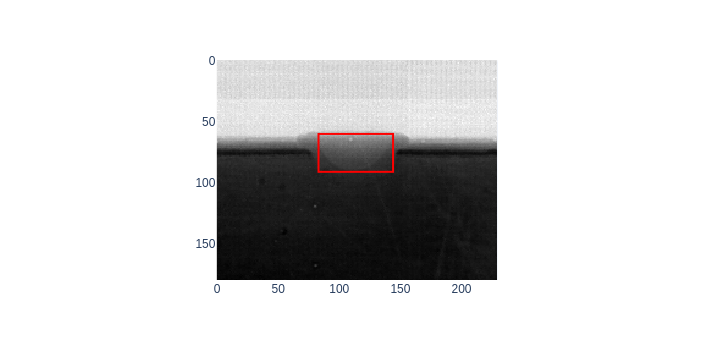

In [9]:
fig = px.imshow(image_sequence[0, :, :], binary_string=True)
fig.add_shape(
        type='rect', x0=minc, y0=minr, x1=maxc, y1=maxr, line=dict(color='Red'))
plotly.io.show(fig)

We are now ready to perform this selection for all image deltas in the
sequence. We shall also store
the bbox information, which will be used to track the
position of the S-L interface.



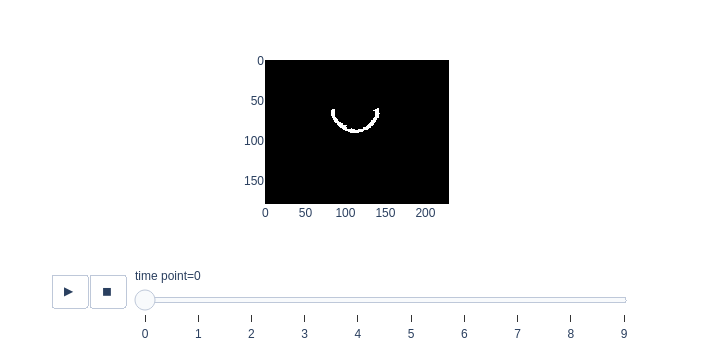

In [10]:
largest_region = np.empty_like(binarized)
bboxes = []

for i in range(binarized.shape[0]):
    labeled = measure.label(binarized[i, :, :])
    props = measure.regionprops_table(
            labeled, properties=('label', 'area', 'bbox'))
    props_df = pd.DataFrame(props)
    props_df = props_df.sort_values('area', ascending=False)
    largest_region[i, :, :] = (labeled == props_df.iloc[0]['label'])
    bboxes.append([props_df.iloc[0][f'bbox-{i}'] for i in range(4)])
fig = px.imshow(
    largest_region,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'time point'}
)
plotly.io.show(fig)

## Plot interface location over time
The final step in this analysis is to plot the location of the S-L
interfaces over time. This can be achieved by plotting ``maxr``
(third element in bbox)
over time since this value shows the `y` location of the bottom of
the interface. The pixel size in this experiment was 1.93 microns
and the framerate was 80,000 frames per second, so these values
are used to convert pixels and image number to physical units.
We calculate the average solidfication velocity by fitting a linear
polynomial to the scatter plot. The velocity is the first-order coefficient.



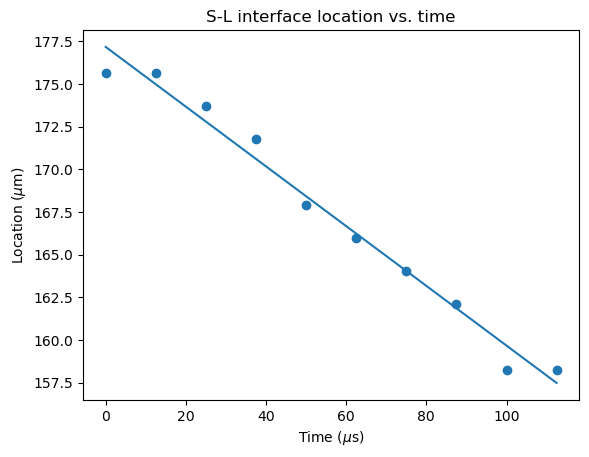

In [11]:
ums_per_pixel = 1.93
fps = 80000
interface_y_um = [ums_per_pixel * bbox[2] for bbox in bboxes]
time_us = 1e6 / fps * np.arange(len(interface_y_um))
fig, ax = plt.subplots(dpi=100)
ax.scatter(time_us, interface_y_um)
c0, c1 = np.polynomial.polynomial.polyfit(time_us, interface_y_um, 1)
ax.plot(time_us, c1 * time_us + c0, label=f'Velocity: {abs(round(c1, 3))} m/s')
ax.set_title('S-L interface location vs. time')
ax.set_ylabel(r'Location ($\mu$m)')
ax.set_xlabel(r'Time ($\mu$s)')
plt.show()